Mask RCNN Approach For Cloud Detection in satellite images

1) Manual Annotation of images

2) From all the images given, three major cloud portions were identified

3) On training and testing the Mask RCNN model on images from the visible channel it was understood that the cloud regions are not uniform due to the daylight that can be eventually seen in the images.

4) On training and testing the Mask RCNN model on images from the infrared channel it was found that there are three major cloud regions

5) The model is fine tuned on the coco weights.

6) It is run for 10 epochs with a batch size of 75.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# !pip install 'tensorflow==1.14.0'
# !pip install 'tensorflow==1.15.0'
# !pip install 'tensorflow-gpu==1.15'  # GPU
# !pip install 'keras==2.0.8'

In [4]:
# Code to train Mask RCNN model intially
#  !python3 '/content/drive/My Drive/Mask_RCNN/cloud.py' train --dataset="/content/drive/My Drive/Mask_RCNN/Cloud_Dataset" --weights=coco

In [5]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

# Root directory of the project
ROOT_DIR = os.path.abspath("/content/drive/My Drive/Mask_RCNN")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import cloud

%matplotlib inline

Using TensorFlow backend.


In [6]:
config = cloud.CloudConfig()
CUSTOM_DIR = os.path.join(ROOT_DIR, "Cloud_Dataset")
print(CUSTOM_DIR)

/content/drive/My Drive/Mask_RCNN/Cloud_Dataset


In [7]:
# Load dataset
# Get the dataset from the releases page
# https://github.com/matterport/Mask_RCNN/releases
dataset = cloud.CloudDataset()
print(dataset)
dataset.load_custom(CUSTOM_DIR, "train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 45
Class Count: 2
  0. BG                                                
  1. cloud                                             


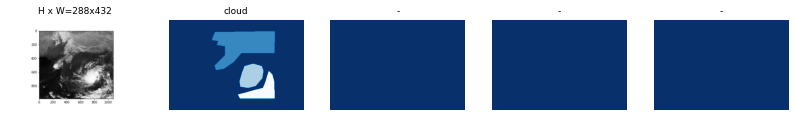

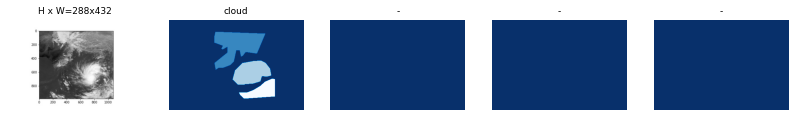

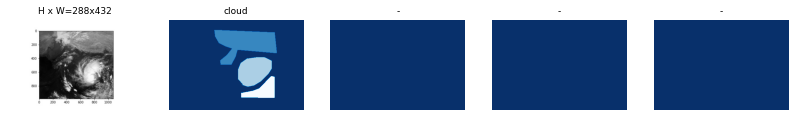

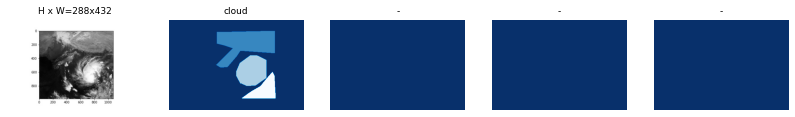

In [8]:

# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

image_id  21 /content/drive/My Drive/Mask_RCNN/Cloud_Dataset/train/satellite22.jpg
image                    shape: (288, 432, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (288, 432, 3)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (3,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (3, 4)                min:   33.00000  max:  341.00000  int32


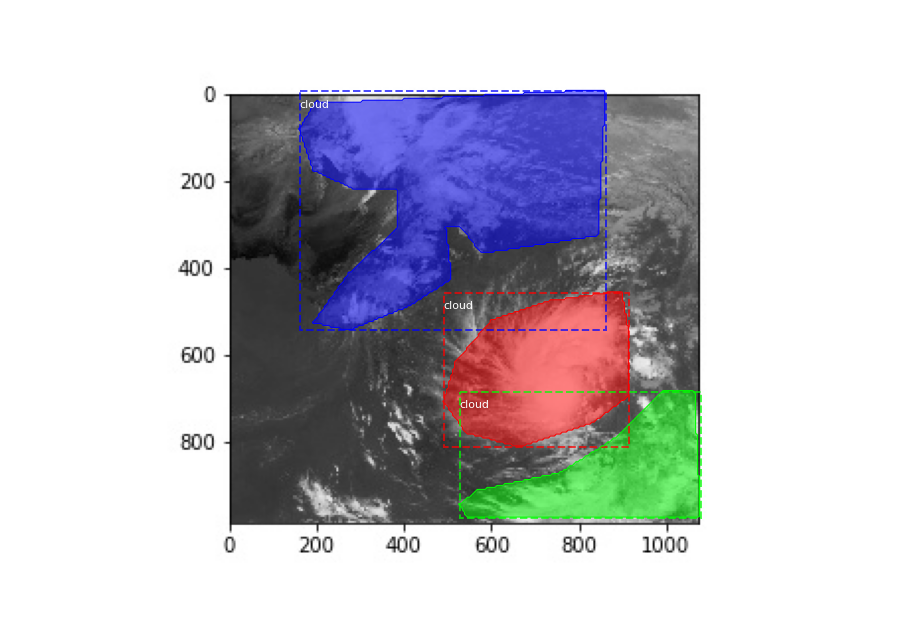

In [9]:
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

Resize the images

In [10]:
# # Load random image and mask.
# image_id = np.random.choice(dataset.image_ids, 1)[0]
# image = dataset.load_image(image_id)
# mask, class_ids = dataset.load_mask(image_id)
# original_shape = image.shape
# # Resize
# image, window, scale, padding, _ = utils.resize_image(
#     image, 
#     min_dim=config.IMAGE_MIN_DIM, 
#     max_dim=config.IMAGE_MAX_DIM,
#     mode=config.IMAGE_RESIZE_MODE)
# mask = utils.resize_mask(mask, scale, padding)
# # Compute Bounding box
# bbox = utils.extract_bboxes(mask)

# # Display image and additional stats
# print("image_id: ", image_id, dataset.image_reference(image_id))
# print("Original shape: ", original_shape)
# log("image", image)
# log("mask", mask)
# log("class_ids", class_ids)
# log("bbox", bbox)
# # Display image and instances
# visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

Validating the model


In [11]:
import os
import cv2
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage
import glob

# Root directory of the project
ROOT_DIR = '/content/drive/My Drive/Mask_RCNN'

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
import cloud
%matplotlib inline 
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

custom_WEIGHTS_PATH = "/content/drive/My Drive/Mask_RCNN/logs/cloud20200715T1252/mask_rcnn_cloud_0009.h5"  # TODO: update this path

In [12]:
config = cloud.CloudConfig()
custom_DIR = os.path.join(ROOT_DIR, "Cloud_Dataset")

In [13]:
#Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [14]:

# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [15]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [16]:
# Load validation dataset
dataset = cloud.CloudDataset()
dataset.load_custom(custom_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 45
Classes: ['BG', 'cloud']


In [17]:

# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,config=config)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [18]:
# load the last model you trained
# weights_path = model.find_last()[1]

# Load weights
print("Loading weights ", custom_WEIGHTS_PATH)
model.load_weights(custom_WEIGHTS_PATH, by_name=True)

Loading weights  /content/drive/My Drive/Mask_RCNN/logs/cloud20200715T1252/mask_rcnn_cloud_0009.h5





Re-starting from epoch 9


In [23]:
model

In [19]:
from importlib import reload 
reload(visualize)

<module 'mrcnn.visualize' from '/content/drive/My Drive/Mask_RCNN/mrcnn/visualize.py'>

image ID: cloud.satellite15.jpg (14) /content/drive/My Drive/Mask_RCNN/Cloud_Dataset/val/satellite15.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
[[241 356 545 738]
 [609 524 771 801]
 [492 511 677 735]]


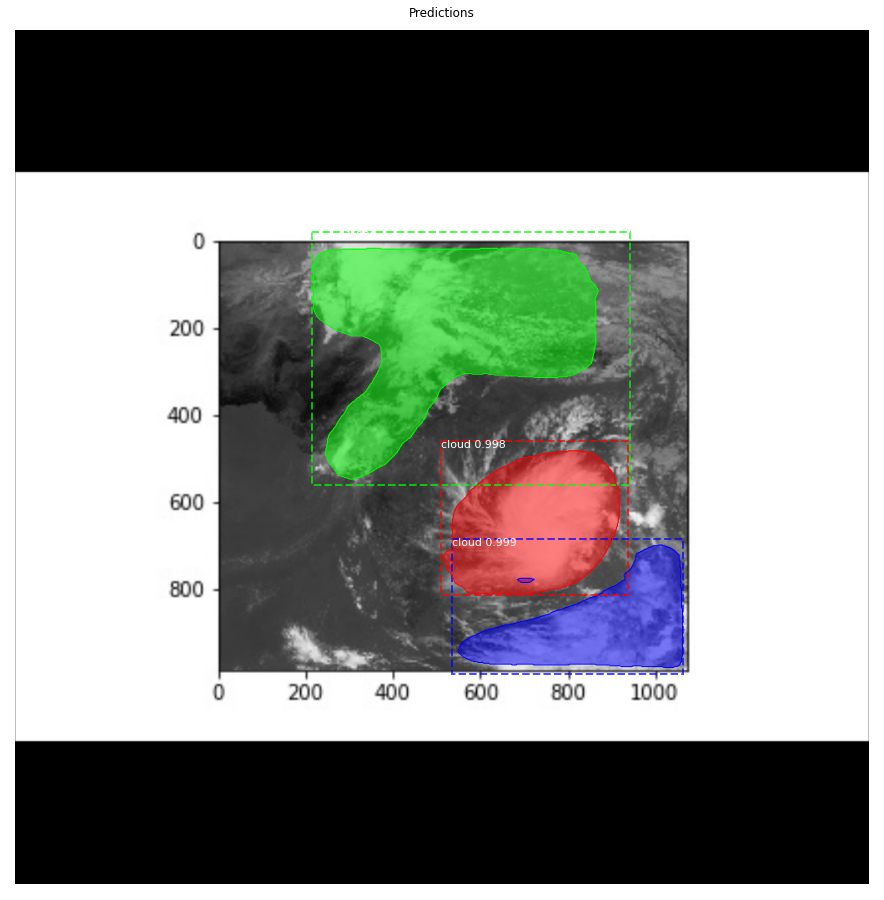

In [20]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
# log("gt_class_id", gt_class_id)
# log("gt_bbox", gt_bbox)
print(r['rois'])
# print(r['masks'])
# log("gt_mask", gt_mask)

In [21]:
# import scipy
# IMAGE_DIR = os.path.join(ROOT_DIR, "Cloud_Dataset/test/")
# file_names = next(os.walk(IMAGE_DIR))[2]
# image = scipy.misc.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# results = model.detect([image], verbose=0)

# r = results[0]
# visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

In [ ]:
# !pip install scipy==1.1.0
